<a href="https://colab.research.google.com/github/marcobiazzo/ImageRecognition/blob/main/ImageRecognitionNoAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Cats and Dogs: Entrenamiento de una CNN (modelo 1)**

In [ ]:
COLAB = True

In [ ]:
if COLAB:
    %tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# Extendido de:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

Using TensorFlow backend.


In [ ]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1tKYqJxfnFF_bBbdra3qKBgD9bH-CpbKp',
                                        dest_path='./prepara_datos_imagenes.py')

In [ ]:
!ls

prepara_datos_imagenes.py  sample_data


In [ ]:
# dimensions of our images.
img_width, img_height = 150, 150
#img_width, img_height = 20, 20

dimensions = (img_height, img_width)

In [ ]:
import glob
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import os
try:
    from google_drive_downloader import GoogleDriveDownloader as gdd
except:
    get_ipython().system('pip install googledrivedownloader')
    from google_drive_downloader import GoogleDriveDownloader as gdd


def lee_imagenes_directorio(directorio, img_width=150, img_height=150, verbose=False):
    X = []
    ficheros = glob.glob(directorio + '/*')
    if verbose:
        print('  Leyendo ficheros del directorio', directorio)
    for i,f in enumerate(ficheros):
#        if verbose and ((i+1)%250 == 0):
#            print('    Leyendo fichero numero', i+1)
        img = load_img(f, target_size=(img_width, img_height))
        X.append(img_to_array(img))
#    print('    {} ficheros leidos'.format(len(X)))
    return np.array(X)


def crea_fichero_npy(data_dir, img_width, img_height,
                     nombre_fichero_X, nombre_fichero_y):
    X_cats = lee_imagenes_directorio(data_dir + '/cats/',
                                     verbose=True,
                                     img_width=img_width,
                                     img_height=img_height)
    X_dogs = lee_imagenes_directorio(data_dir + '/dogs/',
                                     verbose=True,
                                     img_width=img_width,
                                     img_height=img_height)
    X = np.vstack((X_dogs, X_cats)) / 255
    y = np.array(len(X_dogs)*[1] + len(X_cats)*[0])
#    print("    ", X.shape)
    
    aux = '_' + str(img_width) + 'x' + str(img_height) + '.npy'
    print('  escribiendo fichero '+nombre_fichero_X+aux+' ...')
    np.save(nombre_fichero_X+aux, X)
    print('  escribiendo fichero '+nombre_fichero_y+'.npy ...')
    np.save(nombre_fichero_y+'.npy', y)
    print()


def prepara_datos_imagenes(file_id, dimensions=(150,150)):
    
    img_height, img_width = dimensions
    
    # caso 0: los datos ya están preparados (mi_Xtr, mi_Xva, mi_Xte, lo mismo para y)
    if (all([os.path.isfile('{}_{}x{}.npy'.format(a,img_height,img_width))
             for a in ["mi_Xtr", "mi_Xva", "mi_Xte"]]) and
        all([os.path.isfile(b) for b in ["mi_ytr.npy", "mi_yva.npy", "mi_yte.npy"]])):
        print("Los datos ya estaban listos")
        return
    
    # chequeo si los ficheros small_data/train, validation, test están:
    if any([not os.path.isdir('small_data/{}'.format(a))
            for a in ["train", "validation", "test"]]):
        # en caso de que no, los preparo:
        if not os.path.isfile("small_data.zip"):
            gdd.download_file_from_google_drive(file_id=file_id,
                                                dest_path='./small_data.zip',
                                                overwrite=True,
                                                unzip=True,
                                                showsize=True)
    
    # creo los ficheros numpy con todas las imágenes
    print("Creando ficheros mi_Xtr y mi_ytr ...")
    crea_fichero_npy('small_data/train', img_width, img_height,
                     'mi_Xtr', 'mi_ytr')
    print("Creando ficheros mi_Xva y mi_yva ...")
    crea_fichero_npy('small_data/validation', img_width, img_height,
                     'mi_Xva', 'mi_yva')
    print("Creando ficheros mi_Xte y mi_yte ...")
    crea_fichero_npy('small_data/test0', img_width, img_height,
                     'mi_Xte', 'mi_yte')


In [ ]:
#from prepara_datos_imagenes import prepara_datos_imagenes

prepara_datos_imagenes(file_id="1CpfC-e5doyIQUXoaOUMDLeTL7EKR9UMu",
                       dimensions=dimensions)

104.2 MiB Done.
Unzipping...Done.
Creando ficheros mi_Xtr y mi_ytr ...
  Leyendo ficheros del directorio small_data/train/cats/
  Leyendo ficheros del directorio small_data/train/dogs/
  escribiendo fichero mi_Xtr_150x150.npy ...
  escribiendo fichero mi_ytr.npy ...

Creando ficheros mi_Xva y mi_yva ...
  Leyendo ficheros del directorio small_data/validation/cats/
  Leyendo ficheros del directorio small_data/validation/dogs/
  escribiendo fichero mi_Xva_150x150.npy ...
  escribiendo fichero mi_yva.npy ...

Creando ficheros mi_Xte y mi_yte ...
  Leyendo ficheros del directorio small_data/test0/cats/
  Leyendo ficheros del directorio small_data/test0/dogs/
  escribiendo fichero mi_Xte_150x150.npy ...
  escribiendo fichero mi_yte.npy ...



In [ ]:
!ls small_data/train/dogs

dog.0.jpg    dog.250.jpg  dog.400.jpg  dog.551.jpg  dog.701.jpg  dog.852.jpg
dog.100.jpg  dog.251.jpg  dog.401.jpg  dog.552.jpg  dog.702.jpg  dog.853.jpg
dog.101.jpg  dog.252.jpg  dog.402.jpg  dog.553.jpg  dog.703.jpg  dog.854.jpg
dog.102.jpg  dog.253.jpg  dog.403.jpg  dog.554.jpg  dog.704.jpg  dog.855.jpg
dog.103.jpg  dog.254.jpg  dog.404.jpg  dog.555.jpg  dog.705.jpg  dog.856.jpg
dog.104.jpg  dog.255.jpg  dog.405.jpg  dog.556.jpg  dog.706.jpg  dog.857.jpg
dog.105.jpg  dog.256.jpg  dog.406.jpg  dog.557.jpg  dog.707.jpg  dog.858.jpg
dog.106.jpg  dog.257.jpg  dog.407.jpg  dog.558.jpg  dog.708.jpg  dog.859.jpg
dog.107.jpg  dog.258.jpg  dog.408.jpg  dog.559.jpg  dog.709.jpg  dog.85.jpg
dog.108.jpg  dog.259.jpg  dog.409.jpg  dog.55.jpg   dog.70.jpg	 dog.860.jpg
dog.109.jpg  dog.25.jpg   dog.40.jpg   dog.560.jpg  dog.710.jpg  dog.861.jpg
dog.10.jpg   dog.260.jpg  dog.410.jpg  dog.561.jpg  dog.711.jpg  dog.862.jpg
dog.110.jpg  dog.261.jpg  dog.411.jpg  dog.562.jpg  dog.712.jpg  dog.863.jpg
d

In [ ]:
!ls -la small_data/train/cats

total 22748
drwxr-xr-x 2 root root 36864 Sep  4 13:35 .
drwxr-xr-x 4 root root  4096 Sep  4 13:35 ..
-rw-r--r-- 1 root root 12414 Sep  4 13:35 cat.0.jpg
-rw-r--r-- 1 root root 28377 Sep  4 13:35 cat.100.jpg
-rw-r--r-- 1 root root 11291 Sep  4 13:35 cat.101.jpg
-rw-r--r-- 1 root root 28635 Sep  4 13:35 cat.102.jpg
-rw-r--r-- 1 root root 24853 Sep  4 13:35 cat.103.jpg
-rw-r--r-- 1 root root 18941 Sep  4 13:35 cat.104.jpg
-rw-r--r-- 1 root root  6159 Sep  4 13:35 cat.105.jpg
-rw-r--r-- 1 root root 20232 Sep  4 13:35 cat.106.jpg
-rw-r--r-- 1 root root 23076 Sep  4 13:35 cat.107.jpg
-rw-r--r-- 1 root root 24431 Sep  4 13:35 cat.108.jpg
-rw-r--r-- 1 root root 19702 Sep  4 13:35 cat.109.jpg
-rw-r--r-- 1 root root 34315 Sep  4 13:35 cat.10.jpg
-rw-r--r-- 1 root root 23033 Sep  4 13:35 cat.110.jpg
-rw-r--r-- 1 root root 18176 Sep  4 13:35 cat.111.jpg
-rw-r--r-- 1 root root 29761 Sep  4 13:35 cat.112.jpg
-rw-r--r-- 1 root root 18113 Sep  4 13:35 cat.113.jpg
-rw-r--r-- 1 root root 11327 Sep  4 13

In [ ]:
aux = '_' + str(img_width) + 'x' + str(img_height) + '.npy'
print('leyendo mi_Xtr'+aux+'...')
Xtr = np.load('mi_Xtr'+aux)
print('leyendo mi_Xva'+aux+'...')
Xva = np.load('mi_Xva'+aux)
print('leyendo mi_Xte'+aux+'...')
Xte = np.load('mi_Xte'+aux)
print('leyendo mi_ytr.npy, mi_yva.npy, mi_yte.npy ...')
ytr = np.load('mi_ytr.npy')
yva = np.load('mi_yva.npy')
yte = np.load('mi_yte.npy')

leyendo mi_Xtr_150x150.npy...
leyendo mi_Xva_150x150.npy...
leyendo mi_Xte_150x150.npy...
leyendo mi_ytr.npy, mi_yva.npy, mi_yte.npy ...


In [ ]:
print(Xtr.shape)
print(Xva.shape)
print(Xte.shape)

(2000, 150, 150, 3)
(802, 150, 150, 3)
(2002, 150, 150, 3)


In [ ]:
# Definicion del modelo

input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', #strides=(2,2),
                 input_shape=input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
# aqui empieza la red neuronal 'standard'
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))
model.compile(loss='binary_crossentropy',
#              optimizer=optimizers.RMSprop(lr=1e-4),
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
ytr

array([1, 1, 1, ..., 0, 0, 0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

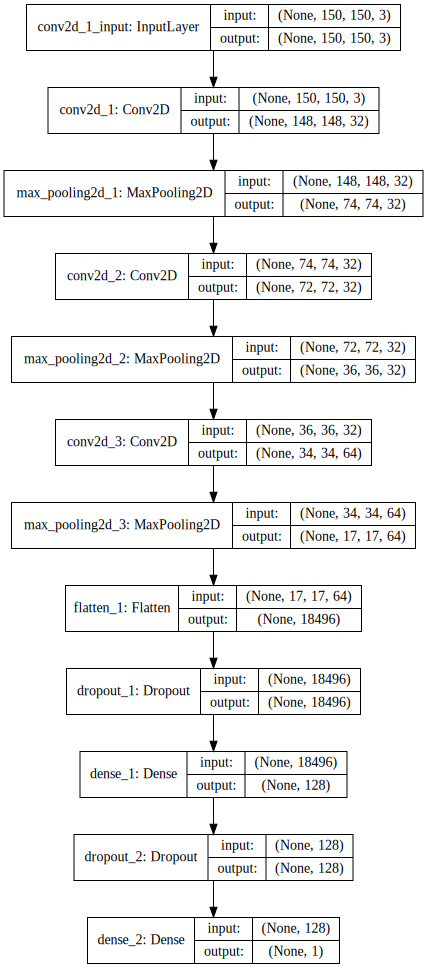

In [ ]:
model.summary()
print("\n\n")
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
acum_tr_acc   = []
acum_val_acc  = []
acum_tr_loss  = []
acum_val_loss = []

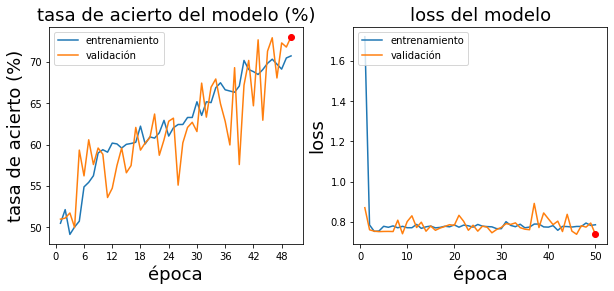

In [ ]:
epochs = 50
batch_size = 16

modelpath="./modelo1.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit(Xtr, ytr,
                        batch_size=batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        validation_data=(Xva, yva))
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model = load_model(modelpath)

## **Resultados obtenidos**

In [ ]:
score_tr = model.evaluate(Xtr, ytr, verbose=1)
print('Train loss    :', score_tr[0])
print('Train accuracy:', score_tr[1])

score_val = model.evaluate(Xva, yva, verbose=1)
print('Val loss    :', score_val[0])
print('Val accuracy:', score_val[1])

score_te = model.evaluate(Xte, yte, verbose=1)
print('Test loss     :', score_te[0])
print('Test accuracy :', score_te[1])

2000/2000 [==============================] - 1s 380us/step
Train loss    : 0.7201811175346374
Train accuracy: 0.7639999985694885
802/802 [==============================] - 0s 297us/step
Val loss    : 0.7385383486153182
Val accuracy: 0.7306733131408691
2002/2002 [==============================] - 1s 336us/step
Test loss     : 0.7551740983149389
Test accuracy : 0.7167832255363464


In [ ]:
if COLAB:
    from google.colab import files
    files.download(modelpath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>